In [1]:
import torch as t
import json
import PIL
import transformers
import torch as t
import matplotlib.pyplot as plt

tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
model = transformers.GPT2LMHeadModel.from_pretrained("gpt2")

In [2]:
class Hook:
    def __init__(self):
        pass
    def __call__(self, module, inp, out):
        self.inp = inp[0].detach()
        self.out = out

hooks = [Hook() for _ in range(12)]

In [3]:
handles = [layer.register_forward_hook(hook) for hook, layer in zip(hooks, model.transformer.h)]

In [4]:
sentence = "The performance of GPU architectures continue to increase with every new generation. Modern GPUs are so fast that, in many cases of interest, the time taken by each GPU operation (e.g. kernel or memory copy) is now measured in microseconds. However, there are overheads associated with the submission of each operation to the GPU – also at the microsecond scale – which are now becoming significant in an increasing number of cases."
tokens = t.tensor(tokenizer.encode(sentence)).unsqueeze(0)
[(i, tokenizer.decode([x])) for i, x in enumerate(tokens[0])]

[(0, 'The'),
 (1, ' performance'),
 (2, ' of'),
 (3, ' GPU'),
 (4, ' architectures'),
 (5, ' continue'),
 (6, ' to'),
 (7, ' increase'),
 (8, ' with'),
 (9, ' every'),
 (10, ' new'),
 (11, ' generation'),
 (12, '.'),
 (13, ' Modern'),
 (14, ' GPUs'),
 (15, ' are'),
 (16, ' so'),
 (17, ' fast'),
 (18, ' that'),
 (19, ','),
 (20, ' in'),
 (21, ' many'),
 (22, ' cases'),
 (23, ' of'),
 (24, ' interest'),
 (25, ','),
 (26, ' the'),
 (27, ' time'),
 (28, ' taken'),
 (29, ' by'),
 (30, ' each'),
 (31, ' GPU'),
 (32, ' operation'),
 (33, ' ('),
 (34, 'e'),
 (35, '.'),
 (36, 'g'),
 (37, '.'),
 (38, ' kernel'),
 (39, ' or'),
 (40, ' memory'),
 (41, ' copy'),
 (42, ')'),
 (43, ' is'),
 (44, ' now'),
 (45, ' measured'),
 (46, ' in'),
 (47, ' micro'),
 (48, 'seconds'),
 (49, '.'),
 (50, ' However'),
 (51, ','),
 (52, ' there'),
 (53, ' are'),
 (54, ' over'),
 (55, 'heads'),
 (56, ' associated'),
 (57, ' with'),
 (58, ' the'),
 (59, ' submission'),
 (60, ' of'),
 (61, ' each'),
 (62, ' operation'),

In [5]:
_ = model(tokens)

In [6]:
for handle in handles:
    handle.remove()

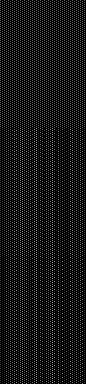

In [7]:
img = (t.sigmoid(t.cat([x.inp[0][:,21].expand(32,-1) for x in hooks], dim=0))*200).to(t.int32)
PIL.Image.fromarray(img.numpy(), mode='L')

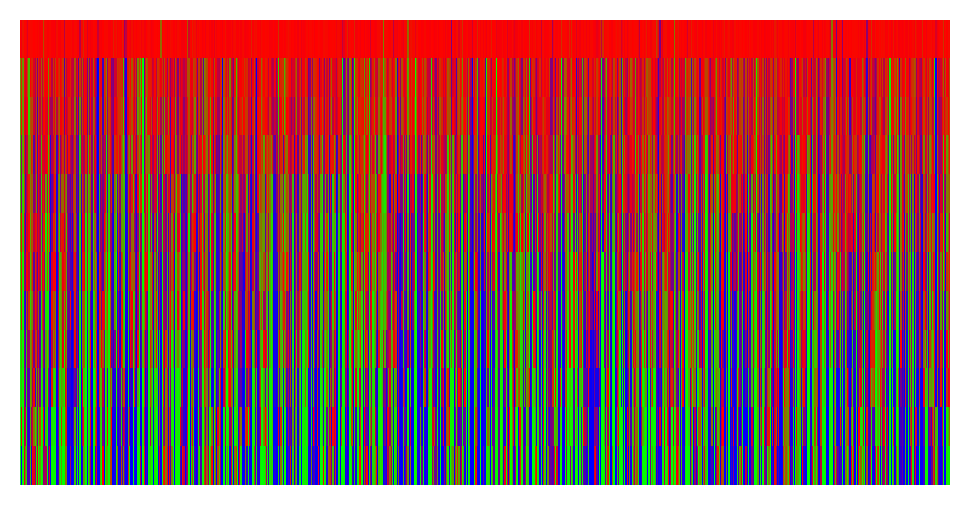

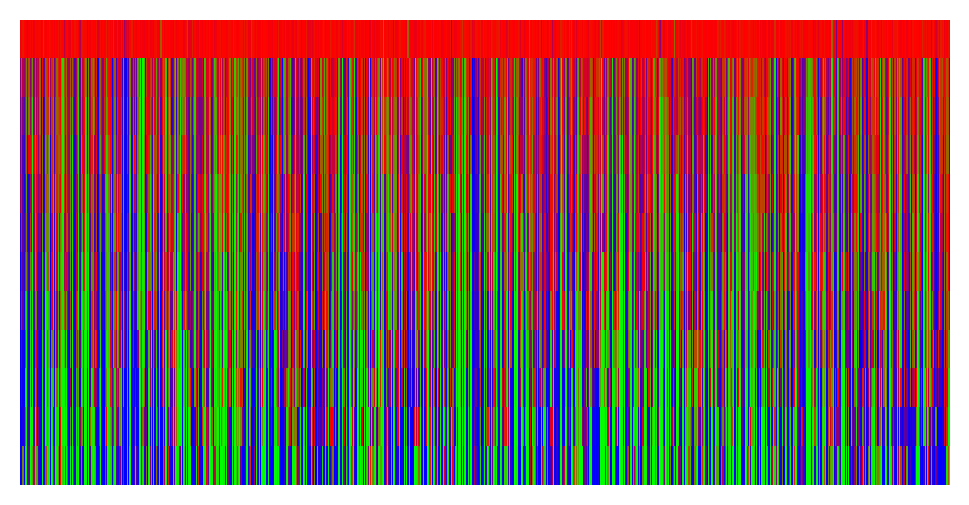

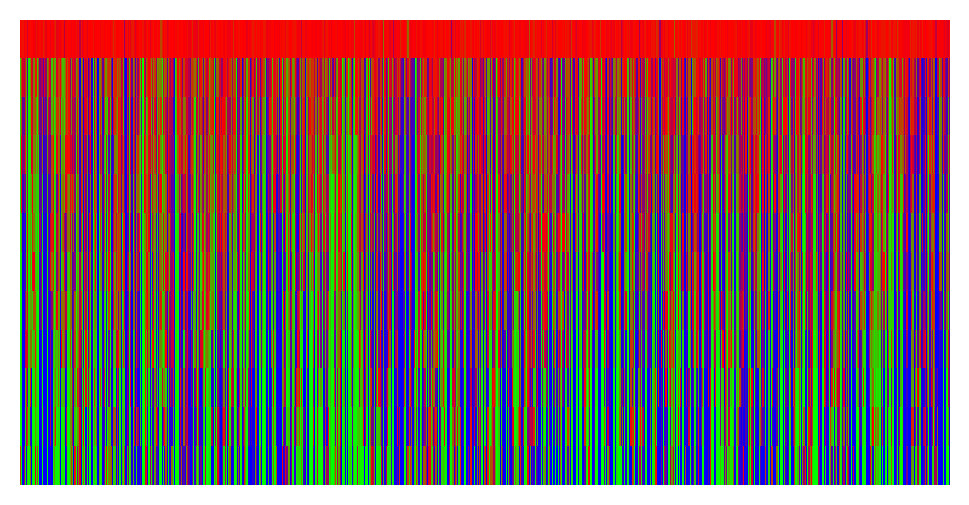

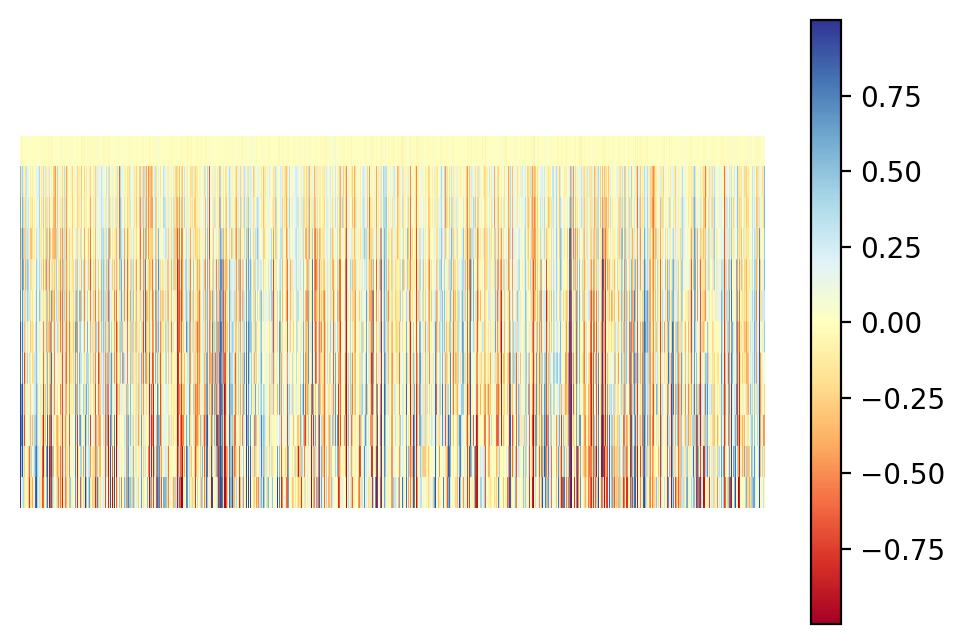

In [135]:
idxs = [6,10,17]
imgs = []
for idx in idxs:
    plt.figure(dpi=200)
    plt.axis('off')
    img = t.cat([t.sigmoid(x.inp[:,idx]).expand(32,-1) for x in hooks], dim=0)
    p = plt.imshow(img, interpolation='nearest')
    imgs.append(img)
    p.set_cmap('brg')
    plt.savefig("seq_21_stream.png")
    plt.show()

plt.figure(dpi=200)
plt.axis('off')
p = plt.imshow(imgs[0]-imgs[1])
p.set_cmap('RdYlBu')
plt.colorbar()
plt.show()

In [9]:
print(hooks)

[<__main__.Hook object at 0x7f85a2411b80>, <__main__.Hook object at 0x7f85a2411bb0>, <__main__.Hook object at 0x7f85a2411c10>, <__main__.Hook object at 0x7f85a2411c70>, <__main__.Hook object at 0x7f85a2411ca0>, <__main__.Hook object at 0x7f85a2411d00>, <__main__.Hook object at 0x7f85a2411dc0>, <__main__.Hook object at 0x7f85a2411df0>, <__main__.Hook object at 0x7f85a2411e20>, <__main__.Hook object at 0x7f85a2411e50>, <__main__.Hook object at 0x7f85a2411f10>, <__main__.Hook object at 0x7f85a2411f40>]


In [10]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [11]:
train_data = t.tensor(json.load(open("test_tokens_owt_subset.json")))

In [12]:
train_data.shape

torch.Size([2048, 513])

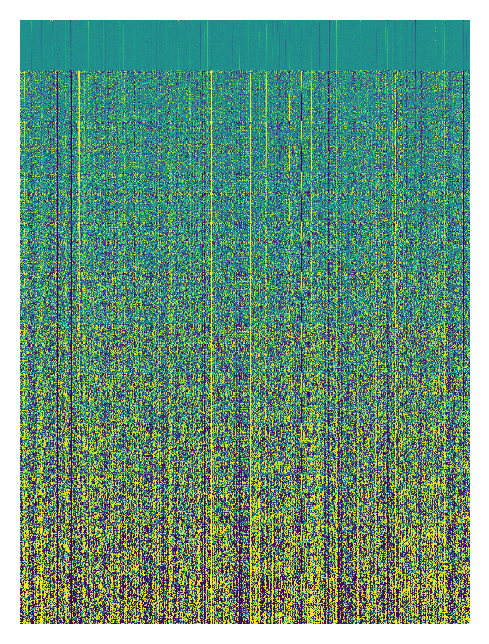

In [141]:
plt.figure(dpi=200)
plt.axis('off')
plt.imshow(t.cat([t.sigmoid(hook.inp.squeeze()) for hook in hooks]), interpolation='nearest')
plt.show()


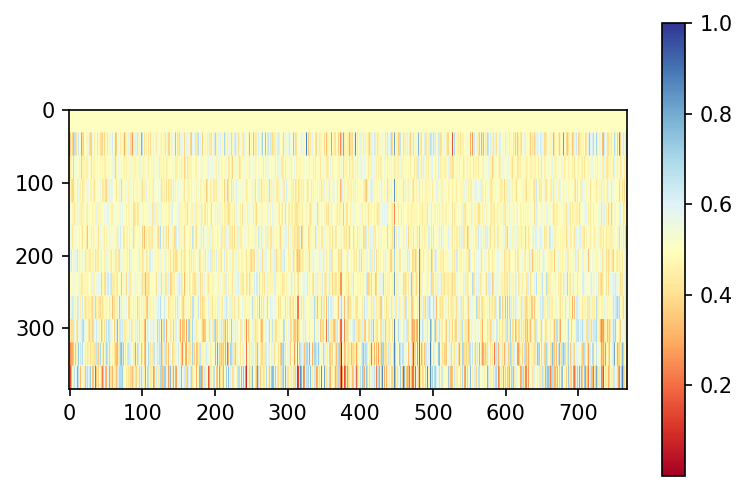

In [14]:
idx = 7
prev = hooks[0].inp[0,idx]
l = []
for hook in hooks:
    curr = hook.inp[0,idx]
    l.append(curr-prev)
    prev = curr

plt.figure(dpi=150)
# plt.axis('off')
p = plt.imshow(t.cat([(t.sigmoid(0.5*x)).expand(32,-1) for x in l]))
# p = plt.imshow(t.cat([(t.sign(x)*t.log(t.abs(x))).expand(32,-1) for x in l]))
# p = plt.imshow(t.cat([(x).expand(32,-1) for x in l]))
plt.colorbar()
p.set_cmap('RdYlBu')


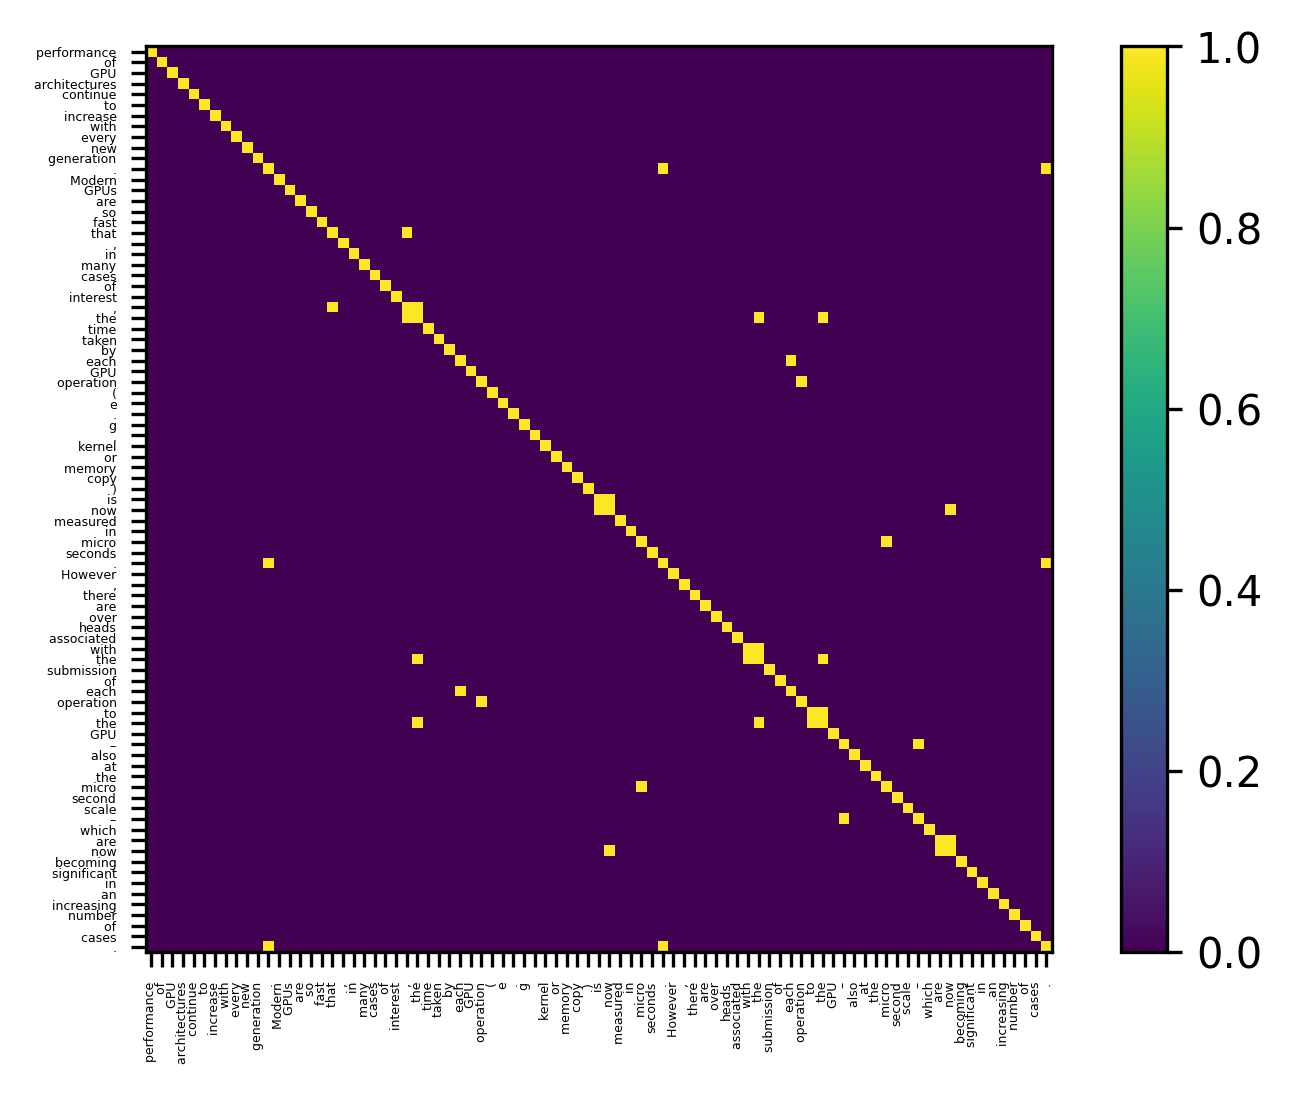

In [15]:
sentence = "The performance of GPU architectures continue to increase with every new generation. Modern GPUs are so fast that, in many cases of interest, the time taken by each GPU operation (e.g. kernel or memory copy) is now measured in microseconds. However, there are overheads associated with the submission of each operation to the GPU – also at the microsecond scale – which are now becoming significant in an increasing number of cases."
tokens = t.tensor(tokenizer.encode(sentence)).unsqueeze(0)

handles = [layer.register_forward_hook(hook) for hook, layer in zip(hooks, model.transformer.h)]
_ = model(tokens)
for handle in handles:
    handle.remove()

x1 = t.cat([t.cat([x.inp[:,idx] for x in hooks] , dim=1) for idx in range(tokens.shape[-1])], dim=0)

plt.figure(dpi=300)
plt.imshow(t.cdist(x1,x1)[1:,1:]<200)
words = [(i, tokenizer.decode([x])) for i, x in enumerate(tokens[0])]
words = [tokenizer.decode([x]) for x in tokens[0]]
plt.xticks(list(range(tokens.shape[-1]-1)), labels=words[1:], fontsize=3, rotation=90)
plt.yticks(list(range(tokens.shape[-1]-1)), labels=words[1:], fontsize=3)
plt.colorbar()

In [16]:
class HookHead:
    def __init__(self, num):
        self.begin = num*64
        self.end = num*64 + 64
        pass
    def __call__(self, module, inp):
        inp[0][:,:,self.begin:self.end] = 0
        return inp

# print(model.transformer.h[0].attn.c_proj.bias.shape)


In [17]:
handle = model.transformer.h[8].attn.c_proj.register_forward_pre_hook(HookHead(0))

In [28]:
_ = model(tokens)
ref = t.cat([t.sigmoid(x.inp[:,idx]).expand(32,-1) for x in hooks], dim=0)
imgs = []
for head_num in range(12):
    handle = model.transformer.h[5].attn.c_proj.register_forward_pre_hook(HookHead(head_num))
    _ = model(tokens)
    handle.remove()
    img = t.cat([t.sigmoid(x.inp[:,idx]).expand(32,-1) for x in hooks], dim=0)
    imgs.append(img)


In [19]:
handle.remove()

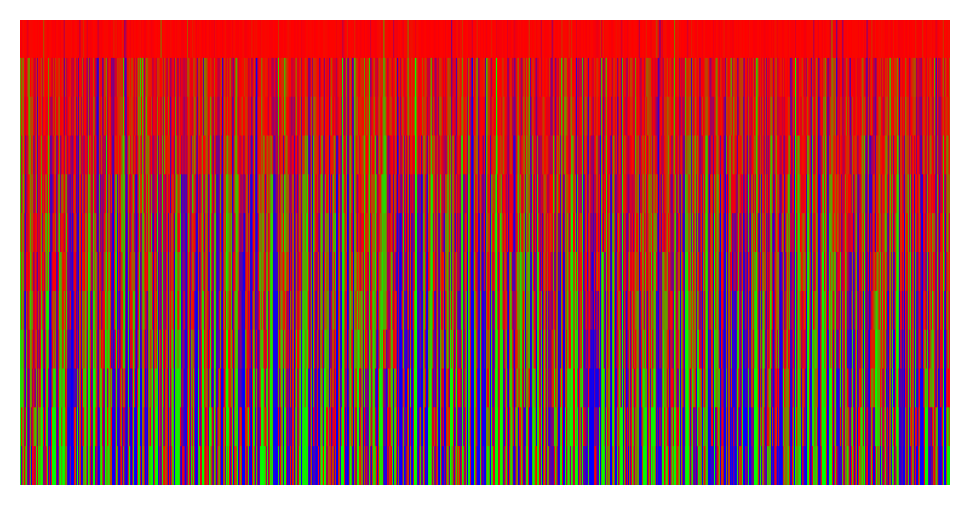

In [27]:
idxs = [6]
imgs = []
for idx in idxs:
    plt.figure(dpi=200)
    plt.axis('off')
    img = t.cat([t.sigmoid(x.inp[:,idx]).expand(32,-1) for x in hooks], dim=0)
    p = plt.imshow(img)
    imgs.append(img)
    p.set_cmap('brg')
    # plt.savefig("seq_21_stream.png")
    plt.show()


In [21]:
_ = model(tokens)


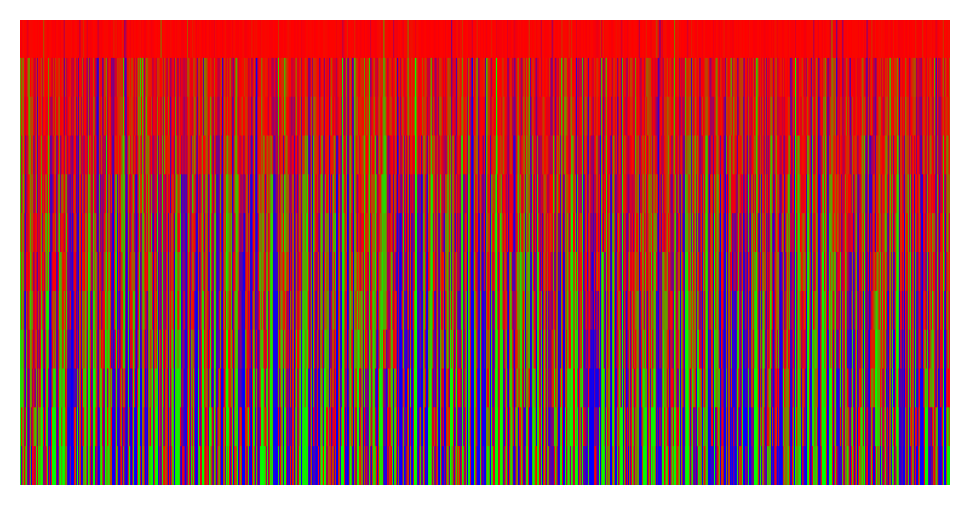

In [22]:
idxs = [6]
for idx in idxs:
    plt.figure(dpi=200)
    plt.axis('off')
    img = t.cat([t.sigmoid(x.inp[:,idx]).expand(32,-1) for x in hooks], dim=0)
    p = plt.imshow(img)
    imgs.append(img)
    p.set_cmap('brg')
    # plt.savefig("seq_21_stream.png")
    plt.show()


tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 0, 1,  ..., 1, 0, 0],
        [1, 0, 1,  ..., 1, 0, 0],
        [1, 0, 1,  ..., 1, 0, 0]], dtype=torch.int32)


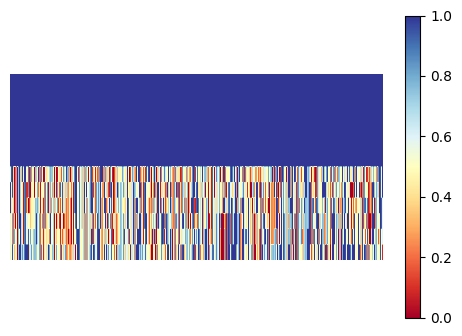

In [134]:
plt.figure(dpi=100)
plt.axis('off')
var = (imgs[0]-imgs[1])<0.001 # img[0] and img[1] are tensors of [384, 768]
# var = var[250:,650:]
print(var.int())
p = plt.imshow(var.int())
p.set_cmap('RdYlBu')
plt.colorbar()
plt.show()

# plt.colorbar()

In [24]:
model.eval()
handle = model.transformer.h[5].attn.c_proj.register_forward_pre_hook(HookHead(head_num))
res = model.(tokens)
handle.remove()


SyntaxError: invalid syntax (<ipython-input-24-c9588dd5a1e9>, line 3)